In [1]:
%matplotlib inline

import os
import sys

PACKAGE_PARENT = '..'
sys.path.append(PACKAGE_PARENT)

import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from gaminet import GAMINetRegressor
from gaminet.utils import local_visualize
from gaminet.utils import global_visualize_density
from gaminet.utils import feature_importance_visualize
from gaminet.utils import plot_trajectory
from gaminet.utils import plot_regularization

## Load data

In [2]:
from dataset import *
random_state = 1
train_x, test_x, train_y, test_y, task_type, meta_info, get_metric = get_bike_share(random_state)

## Compare with EBM

In [3]:
from interpret.glassbox import ExplainableBoostingRegressor

clf = ExplainableBoostingRegressor(interactions=10)
clf.fit(train_x, train_y)

pred_train = clf.predict(train_x)
pred_test = clf.predict(test_x)
ebm_stat = np.hstack([np.round(get_metric(train_y, pred_train),5),
                      np.round(get_metric(test_y, pred_test),5)])
print(ebm_stat)

[83.09317 85.30501]


## Train GAMI-Net 

In [4]:
model = GAMINetRegressor(interact_num=10,
                         meta_info=meta_info,
                         subnet_size_main_effect=[20] * 1,
                         subnet_size_interaction=[20] * 2, 
                         max_epochs=[1000, 1000, 1000],
                         learning_rates=[0.001, 0.001, 0.001],
                         early_stop_thres=["auto", "auto", "auto"],
                         batch_size=1000,
                         reg_clarity=0.1,
                         loss_threshold=0.01,
                         normalize=True,
                         warm_start=True,
                         verbose=True,
                         random_state=random_state)
model.fit(train_x, train_y)

####################Stage 1: Main Effect Training####################
###############Run Warm Initialization for Main Effect###############


Epoch:    1, train loss: 0.01551, validation loss: 0.01476: 100%|██████████| 12/12 [00:00<00:00, 312.52it/s]                       
Epoch:    2, train loss: 0.01532, validation loss: 0.01472: 100%|██████████| 12/12 [00:00<00:00, 337.87it/s]                       
Epoch:    3, train loss: 0.01528, validation loss: 0.01469: 100%|██████████| 12/12 [00:00<00:00, 398.33it/s]                       
Epoch:    4, train loss: 0.01525, validation loss: 0.01469: 100%|██████████| 12/12 [00:00<00:00, 399.57it/s]                       
Epoch:    5, train loss: 0.01523, validation loss: 0.01466: 100%|██████████| 12/12 [00:00<00:00, 400.13it/s]                       
Epoch:    6, train loss: 0.01522, validation loss: 0.01468: 100%|██████████| 12/12 [00:00<00:00, 397.58it/s]                       
Epoch:    7, train loss: 0.01524, validation loss: 0.01468: 100%|██████████| 12/12 [00:00<00:00, 395.41it/s]                       
Epoch:    8, train loss: 0.01520, validation loss: 0.01468: 100%|██████████|

Main Effect Training Stop at Epoch: 50, train loss: 0.01509, validation loss: 0.01466
####################Stage 2: Interaction Training####################
###############Run Warm Initialization for Interaction###############


Epoch:    1, train loss: 0.00649, validation loss: 0.00574: 100%|██████████| 12/12 [00:00<00:00, 97.11it/s]                        
Epoch:    2, train loss: 0.00616, validation loss: 0.00575: 100%|██████████| 12/12 [00:00<00:00, 95.64it/s]                        
Epoch:    3, train loss: 0.00603, validation loss: 0.00563: 100%|██████████| 12/12 [00:00<00:00, 93.84it/s]                        
Epoch:    4, train loss: 0.00595, validation loss: 0.00569: 100%|██████████| 12/12 [00:00<00:00, 99.63it/s]                        
Epoch:    5, train loss: 0.00594, validation loss: 0.00555: 100%|██████████| 12/12 [00:00<00:00, 99.45it/s]                        
Epoch:    6, train loss: 0.00586, validation loss: 0.00562: 100%|██████████| 12/12 [00:00<00:00, 98.14it/s]                        
Epoch:    7, train loss: 0.00584, validation loss: 0.00558: 100%|██████████| 12/12 [00:00<00:00, 96.86it/s]                        
Epoch:    8, train loss: 0.00581, validation loss: 0.00568: 100%|██████████|

Interaction Training Stop at Epoch: 26, train loss: 0.00555, validation loss: 0.00551
#########################Stage 3: Fine Tuning#########################


Epoch:    1, train loss: 0.00635, validation loss: 0.00582: 100%|██████████| 12/12 [00:00<00:00, 93.72it/s]                        
Epoch:    2, train loss: 0.00578, validation loss: 0.00564: 100%|██████████| 12/12 [00:00<00:00, 93.36it/s]                        
Epoch:    3, train loss: 0.00555, validation loss: 0.00533: 100%|██████████| 12/12 [00:00<00:00, 96.72it/s]                        
Epoch:    4, train loss: 0.00549, validation loss: 0.00534: 100%|██████████| 12/12 [00:00<00:00, 97.05it/s]                        
Epoch:    5, train loss: 0.00548, validation loss: 0.00530: 100%|██████████| 12/12 [00:00<00:00, 96.75it/s]                        
Epoch:    6, train loss: 0.00547, validation loss: 0.00531: 100%|██████████| 12/12 [00:00<00:00, 96.73it/s]                        
Epoch:    7, train loss: 0.00546, validation loss: 0.00531: 100%|██████████| 12/12 [00:00<00:00, 88.49it/s]                        
Epoch:    8, train loss: 0.00545, validation loss: 0.00535: 100%|██████████|

Fine Tuning Stop at Epoch: 12, train loss: 0.00551, validation loss: 0.00531


In [5]:
pred_train = model.predict(train_x)
pred_test = model.predict(test_x)
gaminet_stat = np.hstack([np.round(get_metric(train_y, pred_train),5),
                          np.round(get_metric(test_y, pred_test),5)])
print(gaminet_stat)

[71.9311  74.25916]


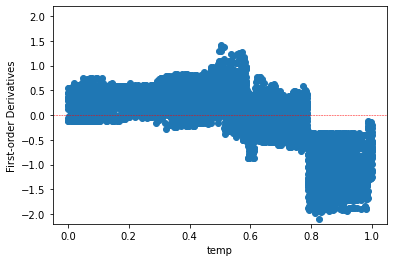

In [6]:
model.partial_derivatives(6)

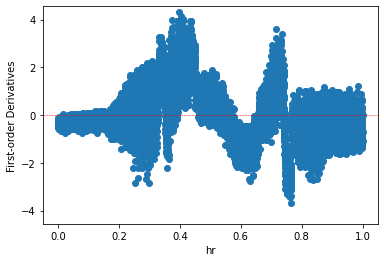

In [7]:
model.partial_derivatives(2)

In [8]:
model.get_mono_loss(train_x), model.certify_mono(n_samples=10000)

(0.0, True)

In [9]:
model.get_clarity_loss(test_x)

0.0006336922524496913

## Visualization

In [10]:
simu_dir = "./results/"
if not os.path.exists(simu_dir):
    os.makedirs(simu_dir)

Training details

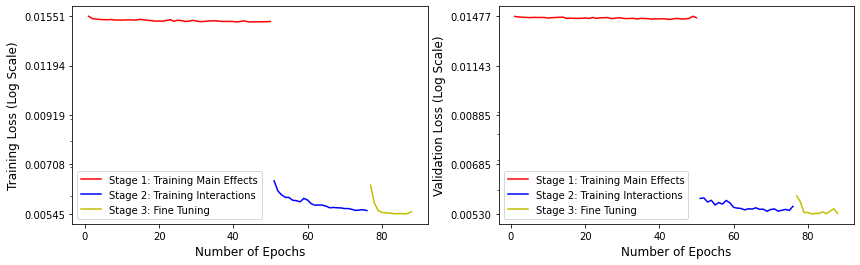

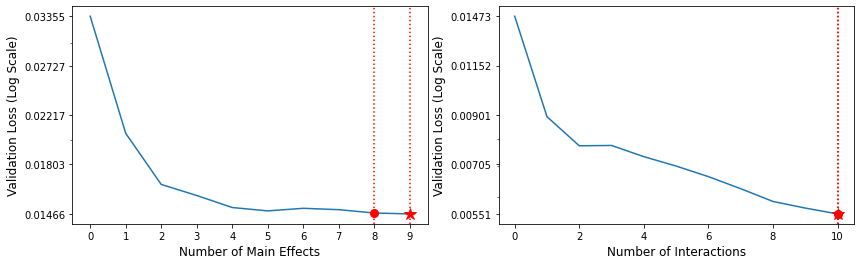

In [11]:
data_dict_logs = model.summary_logs(save_dict=False)
plot_trajectory(data_dict_logs, folder=simu_dir, name="s1_traj_plot", log_scale=True, save_png=True, save_eps=False)
plot_regularization(data_dict_logs, folder=simu_dir, name="s1_regu_plot", log_scale=True, save_png=True, save_eps=False)

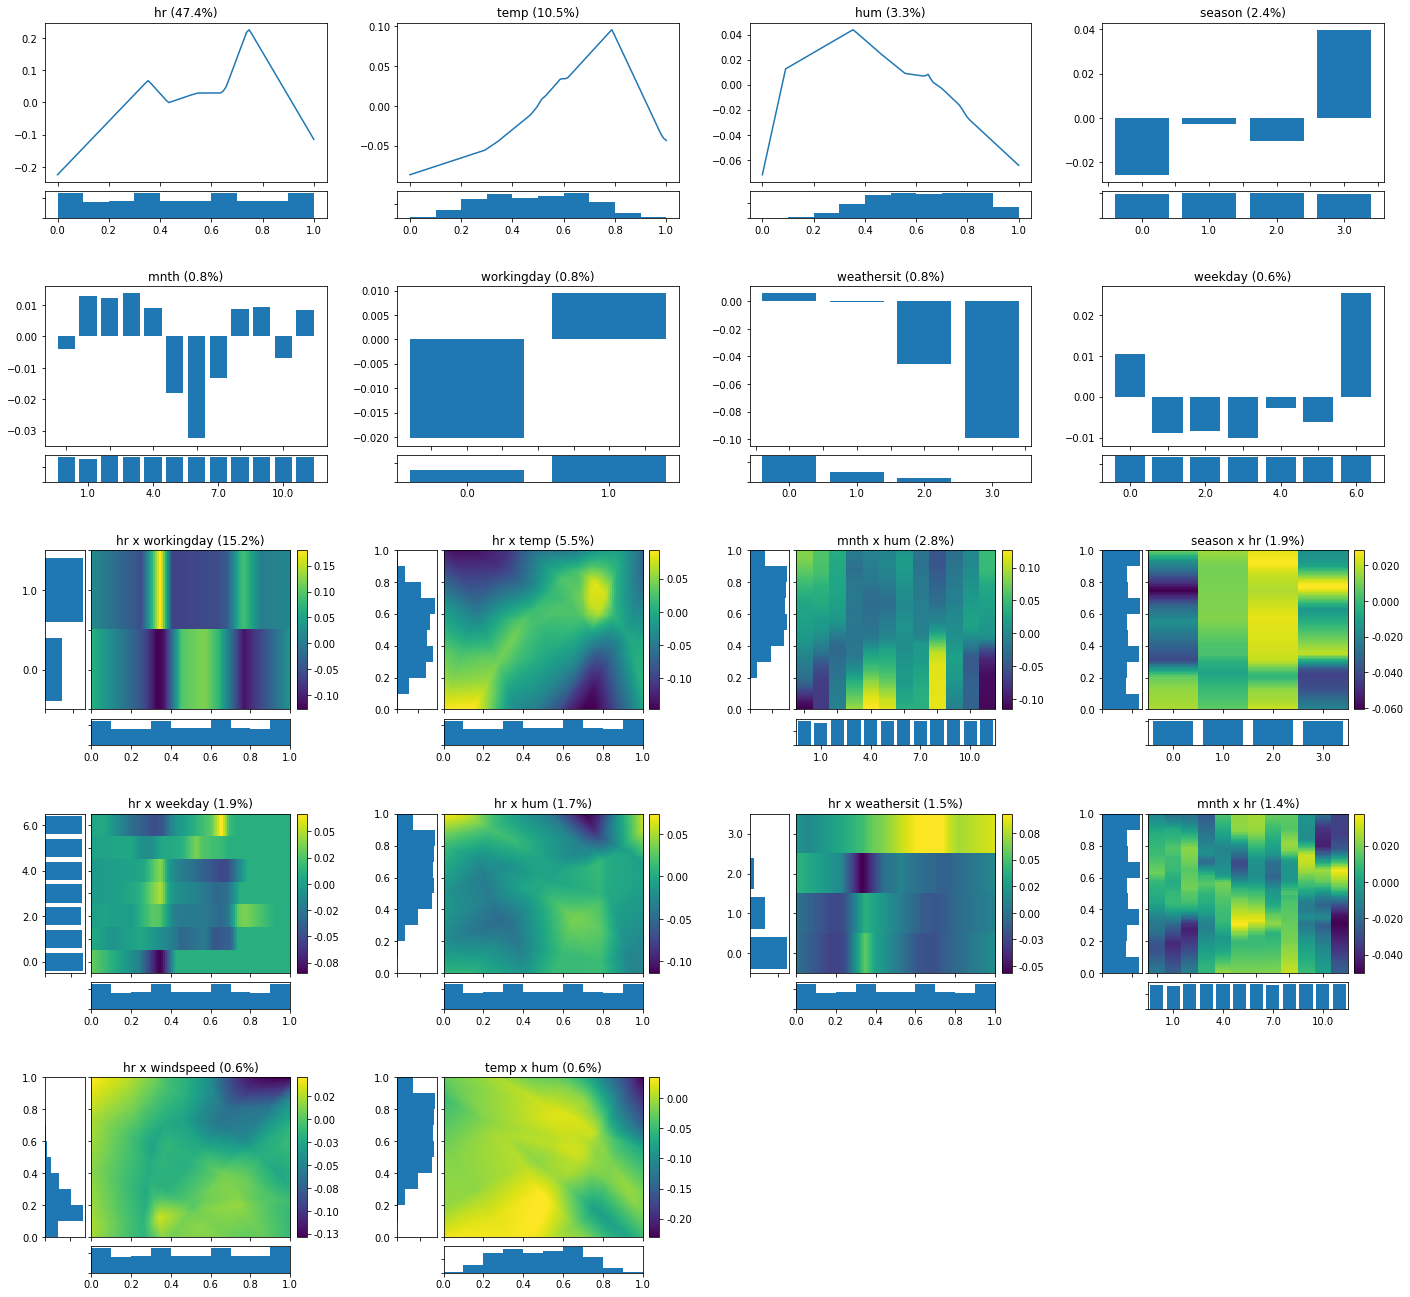

In [12]:
data_dict_global = model.global_explain(save_dict=False)
global_visualize_density(data_dict_global, main_effect_num=10, interaction_num=10, cols_per_row=4, save_png=True, save_eps=True)

Feature Importance

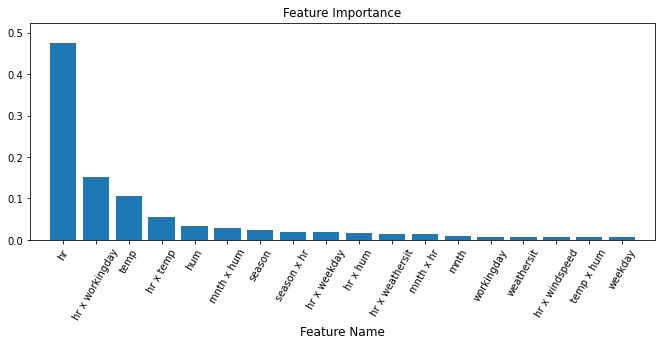

In [13]:
feature_importance_visualize(data_dict_global, save_png=True, folder=simu_dir, name='s1_feature')

Local Visualization

In [14]:
data_dict_local = model.local_explain(train_x[:10], train_y[:10], save_dict=False)

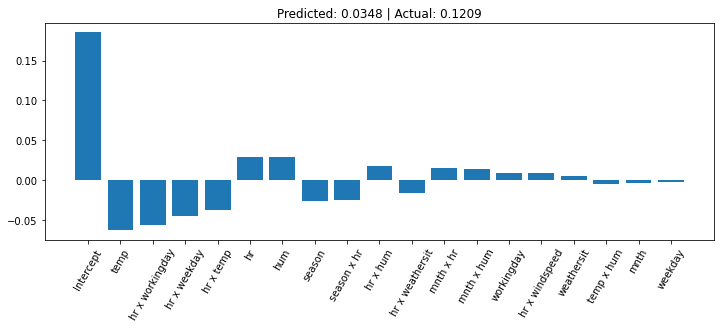

In [15]:
local_visualize(data_dict_local[0], save_png=True, folder=simu_dir, name='s1_local')